In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20, 10)

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
import pickle

In [5]:
df = pd.read_csv('bengaluru_house_prices.csv')
# df['area_type'].unique()
df.drop(['area_type', 'society', 'balcony', 'availability'], axis='columns', inplace=True)
# df.isnull().sum()
df.dropna(inplace=True)
df['bhk'] = df['size'].apply(lambda x: int(x.split(' ')[0]))

# total_sqft feature; To see values that are not numbers
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True
df[~df['total_sqft'].apply(is_float)] 

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
...,...,...,...,...,...,...
12975,Whitefield,2 BHK,850 - 1060,2.0,38.190,2
12990,Talaghattapura,3 BHK,1804 - 2273,3.0,122.000,3
13059,Harlur,2 BHK,1200 - 1470,2.0,72.760,2
13265,Hoodi,2 BHK,1133 - 1384,2.0,59.135,2


**Above shows that total_sqft can be a range (e.g. 2100-2850). For such case we can just take average of min and max value in the range. There are other cases such as 34.46Sq. Meter which one can convert to square ft using unit conversion. I am going to just drop such corner cases to keep things simple**

In [7]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0]) + float(tokens[1])) / 2
    try:
        return float(x)
    except:
        return None
    
df['total_sqft'] = df['total_sqft'].apply(convert_sqft_to_num)
df = df[df['total_sqft'].notnull()]

# Add new feature called price per square feet (in INR)
df['price_per_sqft'] = (df['price']*100000) / df['total_sqft']
# df['price_per_sqft'].describe()
df['location'] = df['location'].apply(lambda x: x.strip())

C:\Users\mv639\AppData\Local\Temp\ipykernel_10292\1675737926.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price_per_sqft'] = (df['price']*100000) / df['total_sqft']
C:\Users\mv639\AppData\Local\Temp\ipykernel_10292\1675737926.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['location'] = df['location'].apply(lambda x: x.strip())


**Any location having less than 10 data points should be tagged as "other" location. This way number of categories can be reduced by huge amount. Later on when we do one hot encoding, it will help us with having fewer dummy columns. Normally square ft per bedroom is 300 i.e. 2 bhk apartment is minimum 600 sqft. If we have for example 400 sqft apartment with 2 bhk than that seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum thresold per bhk to be 300 sqft**

In [8]:
location_stats = df['location'].value_counts()
location_stats = location_stats[location_stats>10]
df.location = df.location.apply(lambda x: 'other' if x not in location_stats else x)
df = df[~(df['total_sqft']/df['bhk'] < 300)]  # sq ft per bhk
df.price_per_sqft.describe()

C:\Users\mv639\AppData\Local\Temp\ipykernel_10292\861322114.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.location = df.location.apply(lambda x: 'other' if x not in location_stats else x)


count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

**Here we find that min price per sqft is 267 rs/sqft whereas max is 12000000, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation**

In [9]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        sd = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-sd)) & (subdf.price_per_sqft<(m+sd))]
        df_out = pd.concat([df_out, reduced_df], ignore_index=True)
    return df_out
df = remove_pps_outliers(df)

**Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like**

In [10]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()

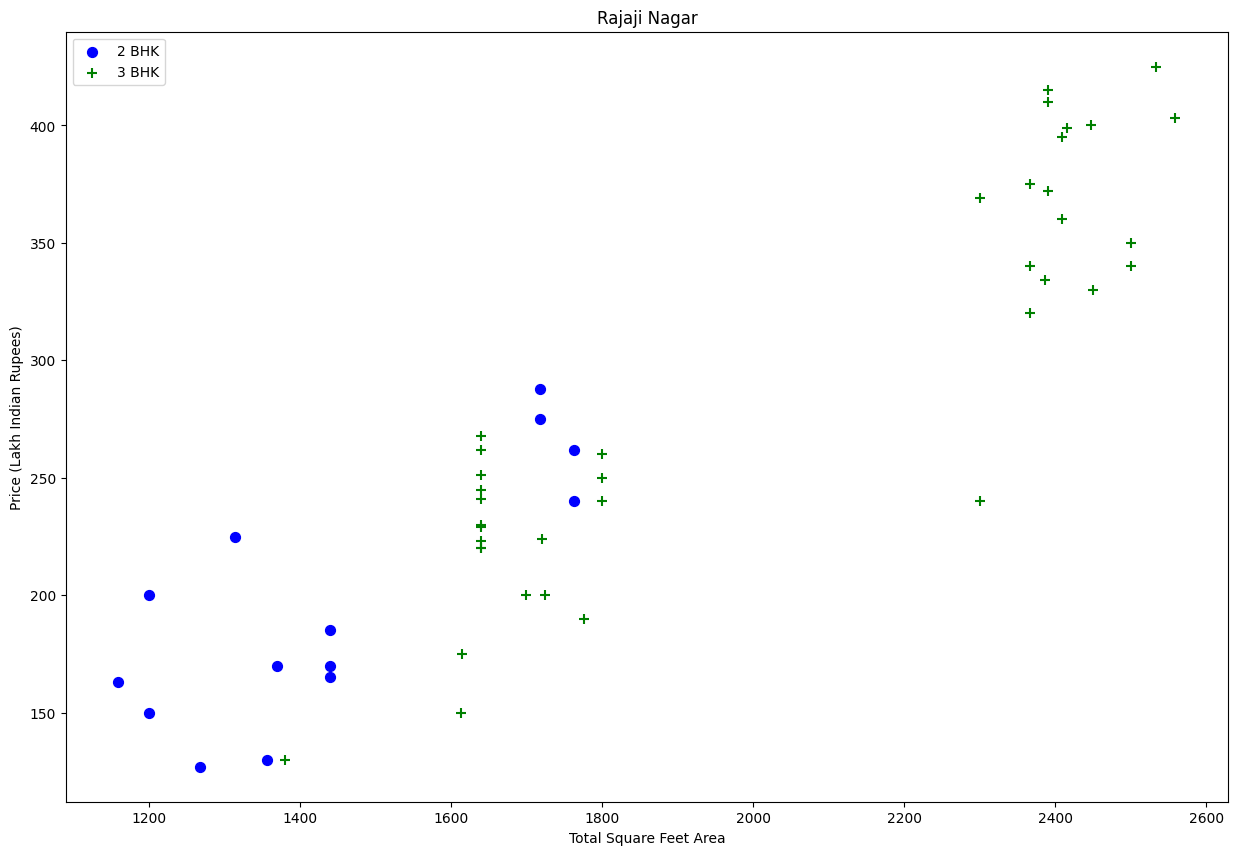

In [11]:
plot_scatter_chart(df, "Rajaji Nagar")

**We should also remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area). What we will do is for a given location, we will build a dictionary of stats per bhk, i.e.**
```
{
    '1' : {
        'mean': 4000,
        'std: 2000,
        'count': 34
    },
    '2' : {
        'mean': 4300,
        'std: 2300,
        'count': 22
    },    
}
```
**Now we can remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment**

In [12]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df = remove_bhk_outliers(df)

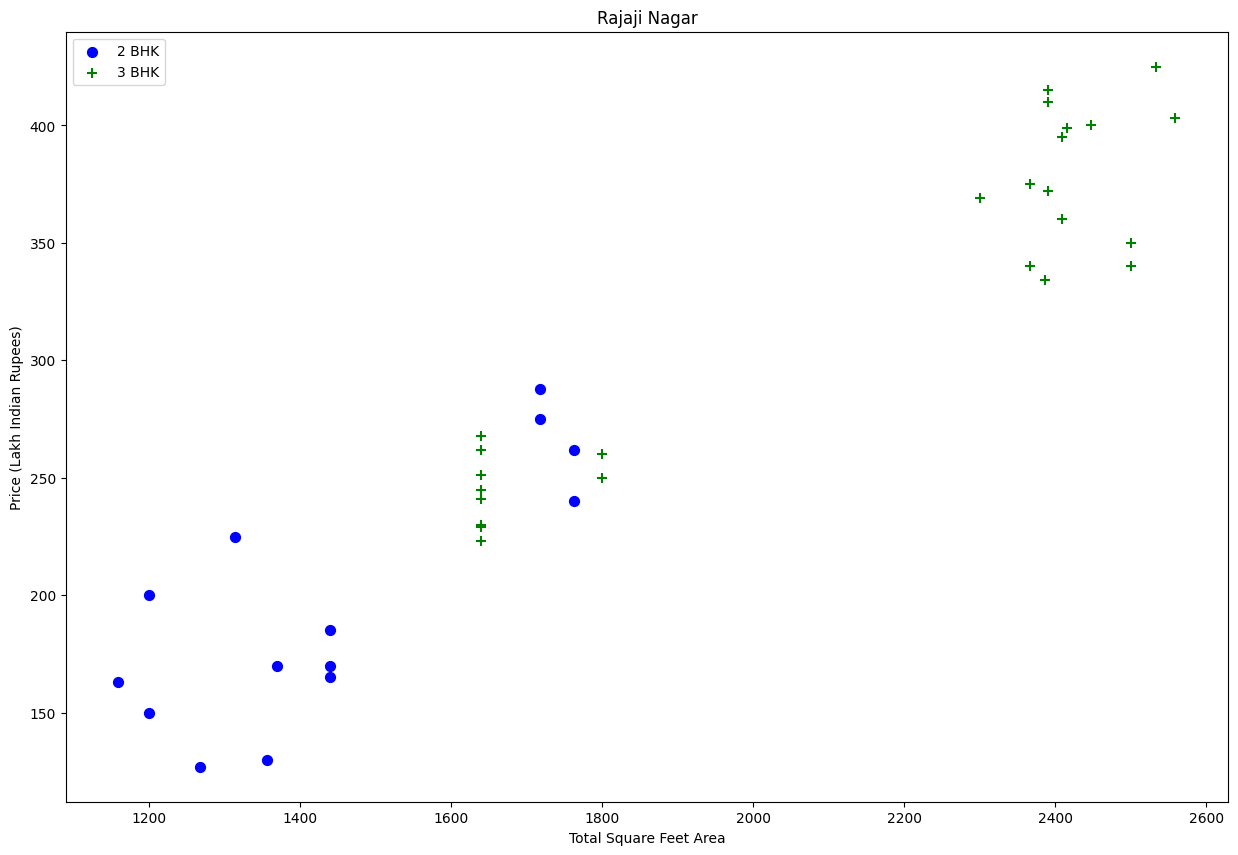

In [13]:
plot_scatter_chart(df,"Rajaji Nagar")

**Based on above charts we can see that data points highlighted in red below are outliers and they are being removed due to remove_bhk_outliers function**

<img src="rajaji_nagar_outliers.png"></img>

Text(0, 0.5, 'Count')

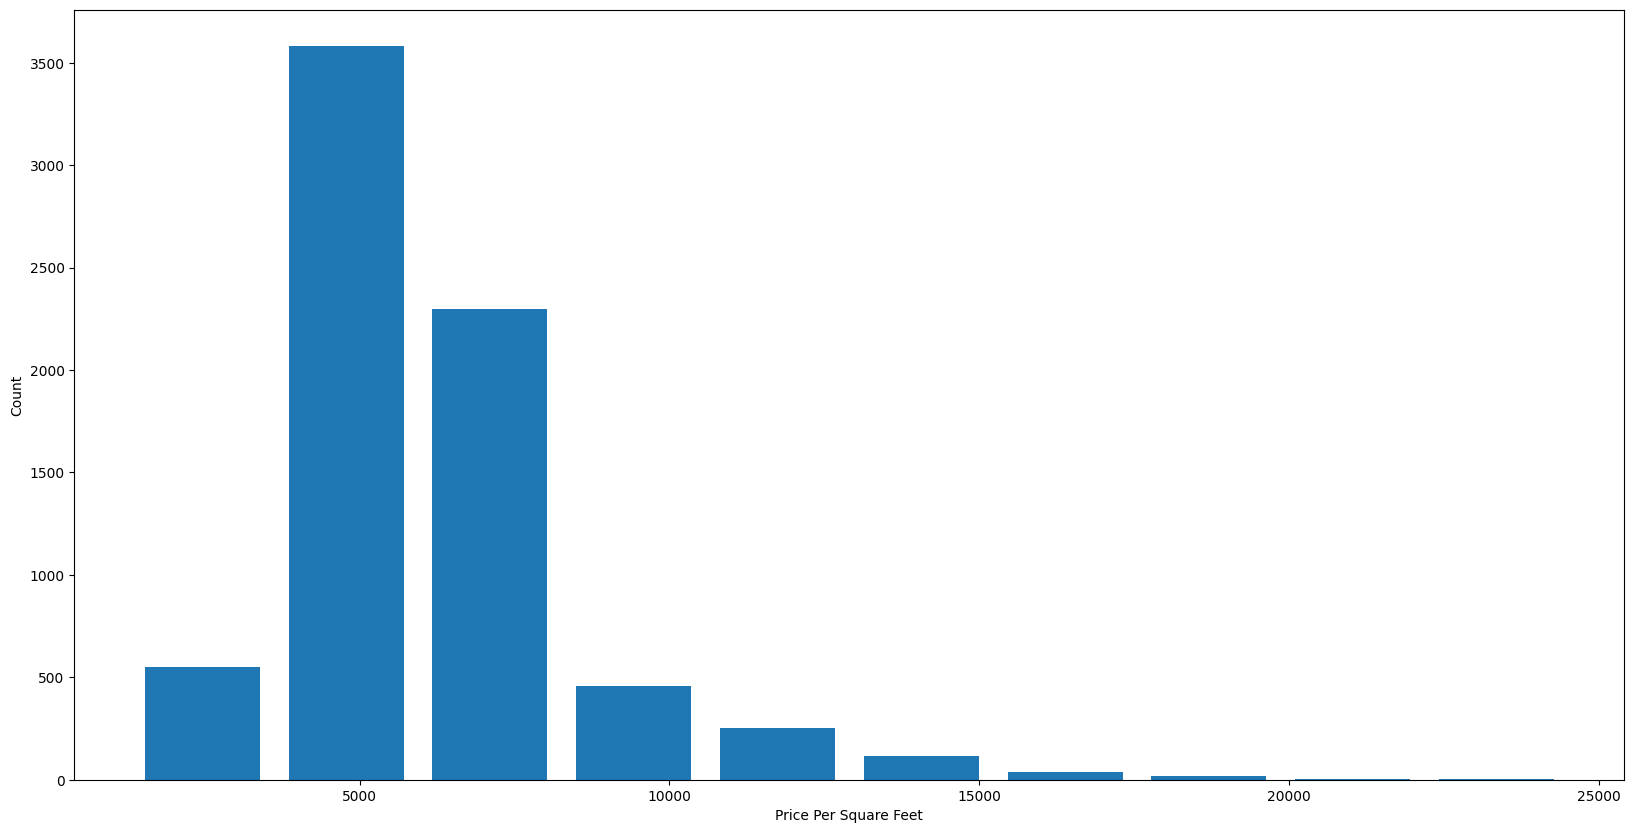

In [14]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

**Outlier Removal Using Bathrooms Feature**

Text(0, 0.5, 'Count')

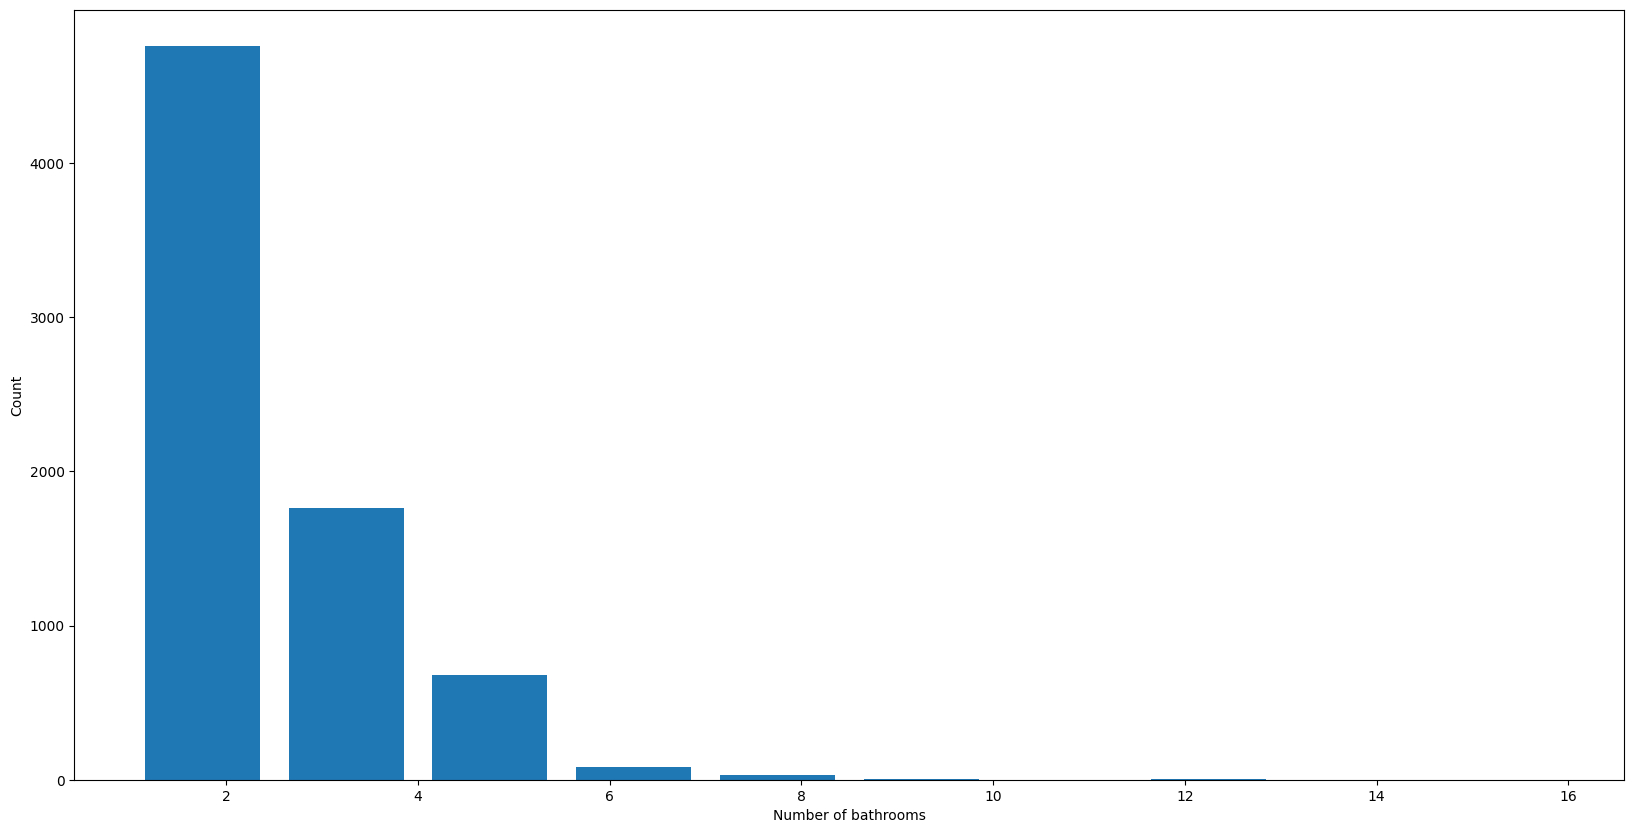

In [15]:
plt.hist(df.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

**It is unusual to have 2 more bathrooms than number of bedrooms in a home**

In [16]:
df = df[df.bath<df.bhk+2]
df = df.drop(['size', 'price_per_sqft'], axis='columns')

# Use One Hot Encoding for Location
dummies = pd.get_dummies(df.location)
df = pd.concat([df.drop('location', axis='columns'), 
                dummies.drop('other', axis='columns')], 
                axis='columns')
df.reset_index(inplace=True)

**Build a Model Now**

In [14]:
X = df.drop(['price'], axis='columns')
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.8,
                                                    test_size=0.2, 
                                                    random_state=10)
lr = LinearRegression()
lr.fit(X_train, y_train)
print(lr.score(X_test, y_test))

# Use K Fold cross validation to measure accuracy of our LinearRegression model
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
print(cross_val_score(LinearRegression(), X, y, cv=cv))

0.8629408963537015
[0.82696277 0.86027938 0.85315902 0.84362001 0.85479752]


**We can see that in 5 iterations we get a score above 80% all the time. This is pretty good but we want to test few other algorithms for regression to see if we can get even better score. We will use GridSearchCV for this purpose**

In [15]:
def best_model(X, y):
    algos = {
        'linear_regression': {
            'model': LinearRegression(),
            'params': {
                'positive': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1, 2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion': ['mse', 'friedman_mse'],
                'splitter': ['best', 'random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs = GridSearchCV(config['model'], 
                          config['params'], 
                          cv=cv, 
                          return_train_score=False)
        gs.fit(X, y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })
    return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])


In [16]:
# best_model(X, y)

**Based on above results we can say that LinearRegression gives the best score. Hence we will use that.**

In [17]:
def predict_price(location, sqft, bath, bhk):
    loc_index = np.where(X.columns==location)[0][0]
# Input of model is a vector of dimensions equal to X.columns
    x = np.zeros(len(X.columns))
    x[1] = sqft
    x[2] = bath
    x[3] = bhk
    if loc_index>=0:
        x[loc_index] = 1
    return lr.predict([x])[0]

In [18]:
print(predict_price('1st Phase JP Nagar',1000, 2, 2))
print(predict_price('1st Phase JP Nagar',1000, 3, 3))
print(predict_price('Indira Nagar',1000, 3, 3))

83.87661311064545
86.08742803951964
197.43197086172808


C:\Users\mv639\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\mv639\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\mv639\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [19]:
# Export the tested model to a pickle file

with open('home_prices_model.pickle', 'wb') as f:
    pickle.dump(lr, f)

# Export location and column information to a file that 
# will be useful later on in our prediction application

import json
columns = {'data_columns': [col.lower() for col in X.columns]}
with open('columns.json', 'w') as f:
    f.write(json.dumps(columns))